# 11. Άσκηση επεξεργασίας και ανάλυσης γεωχωρικών δεδομένων

## Υπολογισμός καμένων εκτάσεων με δορυφορικά δεδομένα Sentinel-2, τον δείκτη Relativized Burn Ratio (RBR) και τον αλγόριθμο ομαδοποίησης k-means.

Στόχος του τρέχοντος jupyter notebook είναι να επιδειχθούν συνοπτικά οι δυνατότητες της Python στην γεωεπεξεργασία και χωρικής ανάλυση.

Σαν μελέτη περίπτωσης επιλέχθηκε η πυρκαγιά στο _Μάτι Αττικής_ στις _23 Ιουλίου 2018_. Σκοπός είναι να αποτυπώσουμε χωρικά την έκταση της πυρκαγιάς, να υπολογίσουμε την έκταση της δομημένης περιοχής που έχει κάει αλλά και να διαπιστώσουμε ποιοί ΟΤΑ έχουν πληγεί περισσότερο. Κατά την εκτέλεση των διαδικασιών προγραμματισμού θα γίνει χρήση μεθόδων τηλεπισκόπησης, δορυφορικών δεδομένων Sentinel2 και διανυσματικών γεωχωρικών δεδομένων.

## Ανάγνωση δεδομένων

Αρχικά γίνεται εισαγωγή των απαραίτητων βοηθητικών βιβλιοθηκών καθώς και ο ορισμός των καταλόγων που περιέχουν τα δεδομένα εισόδου (input data) και τα αποτελέσματα της ανάλυσης (output data).

In [ ]:
import rasterio # βιβλιοθήκη για την ανάγνωση, επεξεργασία και εγγραφή διανυσματικών δεδομένων
from rasterio import features # υπορουτίνα της rasterio για την διαχείριση γεωγραφικών αντικειμένων (features)
import rasterio.mask # υπορουτίνα της rasterio για την δημιουργία Mask σε ψηφιδωτά δεδομένα
from rasterio.crs import CRS # υπορουτίνα της rasterio για την διαχείριση προβολικών συστημάτων
from rasterio.plot import show,show_hist # υπορουτίνα την rasterio για την οπτικοποίηση ψηφιδωτών (raster) δεδομένων 
from rasterio.io import MemoryFile # υπορουτίνα της rasterio για την δημιουργία προσωρινών αρχείων στην μνήμη
from rasterio.warp import reproject, Resampling, calculate_default_transform # υπορουτίνες της rasterio για αλλαγή προβολικού και μετασχηματικό ψηφφιδωτών δεδομένων

import pandas as pd # η βιβλιοθήκη pandas για την διαχείριση και ανάλυση δεδομένων
import geopandas as gpd # επέκταση της βιβλιοθήκης pandas για την διαχείριση και ανάλυση γεωγραφικών δεδομένων
import numpy as np # βιβλιοθήκη για την μαθηματική επεξεργασία πινάκων (arrays)

#from shapely.geometry import shape 
#import fiona # βιβλιοθήκη για την διαχείριση γεωγραφικών αντικειμένων (features)


from matplotlib import pyplot as plt # βιβλιοθήκη για την οπτικοποίηση δεδομένων  σε διαγράμματα
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import folium # οπτικοποίηση γεωγραφικών δεδομένων στην Python μέσω της βιβλιοθήκης leaflet
from sklearn import cluster # υπορουτίνα της scikit-learn για μη επιβλεπόμενη ομαδοποίηση (unsupervised clustering algorithms)

from pathlib import Path # βιβλιοθήκη για την διαχείριση διαδρομών (paths)

from skimage import data, img_as_float # skimage, βιβλιοθήκη για την επεξεργασία εικόνας
from skimage import exposure


# Input directory
INPUTDIR = Path('data')

# Output directory
OUTDIR = Path('output')



Στην συνέχεια ανοίγουμε τα raster από τον Sentinel-2 για ημερομηνία πρίν την φωτιά.
Επίσης εκτυπώνουμε μερικές χρήσιμες ιδιότητες των δεδομένων όπως διαστάσεις 

In [ ]:
with rasterio.open(INPUTDIR / 'pre_fire.tif') as src:
    image = src.read() # θα επιστρέψει ένα numpy array της μορφής [band, row, col].
    #show((src,1),  cmap='pink') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    print(src.crs) # πληροφορίες για το προβολικό σύστημα 
    print("Shape: ", src.shape) # πληροφορίες για τις διαστάσεις του numpy array
    print("Bounds: ", src.bounds) # πληροφορίες για την γεωγραφική έκταση των δεδομένων
    print("Layers: ", src.count) # πληροφορίες για τον αριθμό των layers
    print("Profile: ", src.profile) # τα ανωτέρω περιγράφονται αναλυτικά μέσω του profile property
    print("Mean: ", image[0,:,:].mean()) # ενδεικτικά μπορούμε να πάρουμε μέσο όρο τιμών για το πρώτο layer το οποίο λαμβάνουμε με image[0,:,:]
    
 
    # Βάζουμε τα δεδομένα κάθε καναλιού (band) σε ξεχωριστή μεταβλητή. Θα χρειαστεί στην συνέχεια για τον υπολογισμό δεικτών
    B2_pre,B3_pre,B4_pre,B8_pre,B12_pre   = (image[i,:,:] for i in range(0,src.count))
    
    # λαμβάνουμε το profile σαν ξεχωριστό object. Αυτό το object μπορούμε να το τροποιήσουμε και να το χρησιμοποιήσουμε στην συνέχεια 
    # για τις ανάγκες δημιουργίας νέων αρχείων. 
    dNBR_meta = src.profile
    dNBR_meta.update({'driver':'GTiff',
                     'width':src.shape[1],
                     'height':src.shape[0],
                     'count':1,
                     'dtype':'float64',
                     'crs':src.crs, 
                     'transform':src.transform,
                     'nodata':-9999})

    

Οπτικοποίηση του B2 (B2_pre) καναλιού (πρόκειται για το πρώτο κανάλι= `image[0,:,:]`).
Στην πρώτη προβολή της εικόνας αυτή έχει χαμηλό contrast. 
Για καλύτερη οπτικοποίηση θα επέμβουμε με μια διαδικασία που λέγεται histogram stretching κατά την οποία η εικόνα γίνεται rescaled στο εύρος τιμών που περιλαμβάνονται ανάμεσα στο 2ο και 98ο τεταρτημόριο.

In [ ]:
# Contrast stretching

def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    return(image_rescale)

B2_pre_rescaled, B3_pre_rescaled, B4_pre_rescaled =[contrast_stretching(image) for image in [B2_pre, B3_pre, B4_pre]]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
#show(img_rescale, ax=axr, cmap=plt.cm.gray, transform=dNBR_meta['transform'],)
show(B2_pre,  ax=ax1, cmap=plt.cm.gray,  title='B2 band pre fire (Unscaled image)', transform=dNBR_meta['transform'])
show(B2_pre_rescaled, ax=ax2, cmap=plt.cm.gray, title='B2 band pre fire (Rescaled image)', transform=dNBR_meta['transform'])


Μπορούμε να οπτικοποιήσουμε μια εικόνα _True Color_ που είναι συνδυασμός των καναλιών _B4,B3,B2_ (RGB Composite).

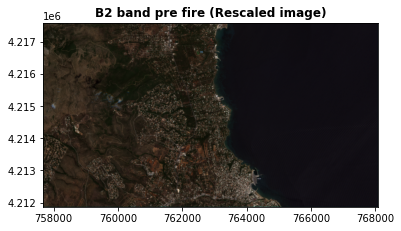

<AxesSubplot:title={'center':'B2 band pre fire (Rescaled image)'}>

In [9]:
# RGB image

# Stack bands

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

rgb = np.dstack((normalize(B4_pre), normalize(B3_pre), normalize(B2_pre) ))

rgb = np.rollaxis(rgb, axis=2) # αναταξινόμηση των διαστάσεων ως [band, row, col], απαιτούμενο για show function της rasterio
show(rgb ,title='B2 band pre fire (Rescaled image)', transform=dNBR_meta['transform']) 


Μέσω της συνάρτησης `show_hist` μπορούμε να δούμε το ιστόγραμμα συχνοτήτων για ένα κανάλι (ή και για όλα τα κανάλια ταυτόχρονα).
Στην παρακάτω γραμμή κώδικα θα εκτυπώσουμε το σχετικό ιστόγραμμα συχνοτήτων για το κανάλι B2 (κανάλι με index 1).

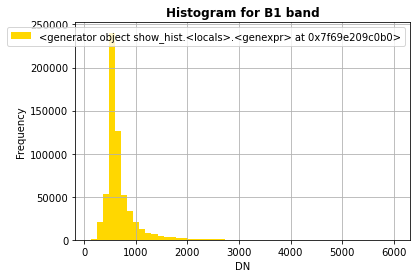

In [10]:
show_hist(B2_pre,  bins=50, lw=0.0, histtype='stepfilled', title="Histogram for B1 band")


Προσπέλαση των δεδομένων Sentinel-2 για μία ημερομηνία μετά την πυρκαγιά.
Βάζουμε επίσης τα επιμέρους κανάλια σε ξεχωριστές μεταβλητές. 

In [11]:
with rasterio.open(INPUTDIR / 'post_fire.tif') as src:
    image = src.read()     
    B2_post,B3_post,B4_post,B8_post,B12_post   = (image[i,:,:] for i in range(0,src.count))

## Υπολογισμός δεικτών

Φτιάχνουμε μια συνάρτηση που υπολογίζει τον δείκτη `Normalized Burn Ratio (NBR)`. 
Περισσότερα για τον δείκτη εδώ. [https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio](https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio)

In [12]:
def NBR(B8, B12):
    NBR = (B8.astype(float)-B12.astype(float)) / (B8.astype(float)+B12.astype(float))
    return(NBR)    

Υπολογίζουμε τον δείκτη `Normalized Burn Ratio`  πριν και μετά την πυρκαγιά (`NBR_pre`, `NBR_post`) και την διαφορά αυτών (`dNBR`).

Χρησιμοποιούνται τα απαραίτητα κανάλια μέσω των σχετικών μεταβλητών που δημιουργήθηκαν πριν.

Στην συνέχεια χρησιμοποιείται ο δείκτης αυτός για να υπολογιστεί ένας πιο αξιόπιστος δείκτης, ο δείκτης `Relativized Burn Ratio (RBR)`. 


In [13]:
# Normalized Burn Ratio
NBR_pre = NBR(B8_pre, B12_pre)
NBR_post = NBR(B8_post, B12_post)

# difference of NBR
dNBR = NBR_pre - NBR_post

#RBR
RBR = dNBR / (NBR_pre + 1.001)


Αποθήκευση του δείκτη RBR ως geotif

In [14]:
with rasterio.open(OUTDIR / 'RBR.tif', 'w', **dNBR_meta) as dst:
        dst.write(RBR.astype(rasterio.float64), 1)


Οι παραπάνω υπολογισμοί αφορούσαν μαθηματικές πράξεις πινάκων (`numpy arrays`). Επίσης τα αποτελέσματα τους είναι απλοί πίνακες.
Όπως προαναφέρθηκε ο κώδικας `image[i,:,:]` που φτιάξαμε τις επιμέρους μεταβλητές (B8, B12 κτλ.) επιστρέφει `numpy arrays`. 
Ο δείκτης `RBR` είναι πίνακας `numpy array` ο οποίος πρέπει να επανασυνδεθεί με την συνοδευτική του χωρική του πληροφορία.
Στην πράξη γράφουμε ένα αρχείο στην μνήμη με χωρικές παραμέτρους που ορίζονται στο αρχικό profile που έχουμε αποθηκεύσει στην μεταβλητή `dNBR_meta`. Στην συνέχεια διαβάζουμε αυτό το αρχείο από την μνήμη και το βάζουμε σε ένα νέo `dataset object` με το όνομα `RBR_rast`. Πλέον ο δείκτης `RBR` έχει χωρική πληροφορία.


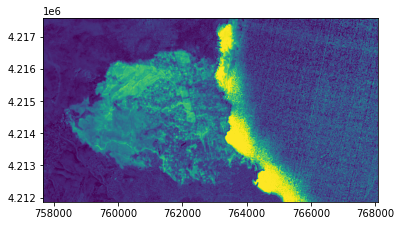

In [15]:

memfile = MemoryFile()

# https://rasterio.readthedocs.io/en/stable/topics/writing.html  
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():
    with MemoryFile() as memfile:
        with memfile.open(**dNBR_meta) as dst:
            dst.write(RBR.astype(rasterio.float64), 1)

        with memfile.open() as dataset:  # Reopen as DatasetReader
            RBR_rast = dataset.read()  
# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.


plot = show(contrast_stretching(RBR_rast[0,:,:]) , cmap='viridis', transform=dNBR_meta['transform'])

### Αλλαγή προβολικού συστήματος με την βιβλιοθήκη rasterio

Επειδή θα χρειαστεί στην συνέχεια να συνδυάσουμε τα δεδομένα raster (δείκτης `RBR`) με διανυσματικά δεδομένα που είναι στο προβολικό σύστημα _ΕΓΣΑ'87_ πρέπει να μετασχήματίσουμε το αρχείο RBR σε _ΕΓΣΑ'87_.
Τον δείκτη `RBR` τον έχουμε αποθηκεύσει παραπάνω ήδη ως geotif με τον πρωτογενές προβολικό σύστημα των δεδομένων Sentinel-2 (_WGS 84 / UTM zone 34N - EPSG:32634_). Μπορούμε να τον ανοίξουμε πάλι, να άλλάξουμε προβολικό σύστημα σε _ΕΓΣΑ'87_ και να τον αποθηκεύσουμε σαν geotif επίσης.

In [16]:

dst_crs = "EPSG:2100"  # web mercator(ie google maps)

with rasterio.open(OUTDIR / "RBR.tif") as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    #print("Source Transform:\n",src_transform,'\n')
    #print("Destination Transform:\n", dst_transform)


     # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open(OUTDIR / "RBR_2100.tif", "w", **dst_kwargs) as dst:
        # iterate through bands
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

## Masking με vector δεδομένα

Το αρχείο του δείκτη RBR που έχουμε αποθηκεύσει σε ΕΓΣΑ87 πρέπει να το κάνουμε masking με τον διανυσματικό αρχείο των ΟΤΑ. Με αυτόν τον τρόπο διατηρούνται μόνο τα δεδομένα στην ξηρά και αποκλείεται η θάλασσα.


<AxesSubplot:>

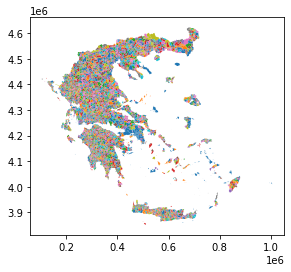

In [19]:
# https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

# Ανάγνωση δεδομένων vector (OTA)
OTA = gpd.read_file("./data/OTA/0adb0521-2223-43cd-96d3-d816ad7a193c.shp").to_crs(2100)
OTA.plot(column='NAME_LATIN')

In [20]:
# Ανάγνωση δείκτη RBR
with rasterio.open(OUTDIR / "RBR_2100.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src,  OTA.geometry, crop=False) # εφαρμόζουμε το mask με βάση τα πολύγωνα των OTA
    out_meta = src.meta # profile για εγγραφή δεδομένων

#
out_meta.update({#"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
                 "nodata": 0,  # ορίζουμε σαν nodata value = 0
#                  "transform": out_transform
                })

# εγγραφή του masked αρχείου σαν geotif
with rasterio.open(OUTDIR / "RBR_2100.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    

Επιβεβαίωση του masking μέσω οπτικοποίησης. 

Κατά το masking που κάναμε με τους OTA όσο pixel δεν τέμνονται με αυτούς πήραν την τιμή 0 (όπως πχ τα pixels της θάλασσας). Για λόγους οπτικοποίησης θέτουμε τις τιμές αυτές σε κενές τιμές (`np.nan`) σε ένα αντιγράφο του αρχείου.

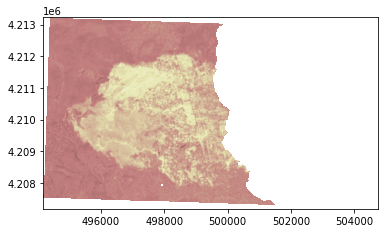

In [21]:
mask_image = np.copy(out_image)
mask_image[mask_image==0] = np.nan
plot = show(mask_image[0,:,:],cmap='pink', transform=out_meta['transform'])

## Eπίπεδο σοβαρότητας (burn severity) καμένης περιοχής

Στην συνέχεια θα δημιουργηθεί ένας χάρτης σοβαρότητας (burn severity) καμένης περιοχής. 
Οι τιμές του δείκτη Relativized Burn Ratio θα κατηγοριοποιηθούν με βάση τον παρακάτω πίνακα:

![severity](data/severity.png)

_Burn severity classes and thresholds proposed by USGS. Color coding established by UN-SPIDER.
Πήγη: [https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine)._
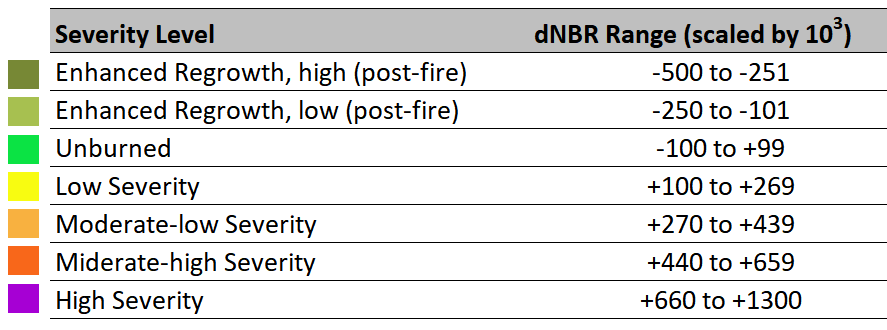

In [22]:
bins = np.array([-np.Inf, -250, -100, 100, 270, 440, 660, np.Inf])/10**3 # κατηγορίες
burn_severity = np.digitize(out_image, bins, right=False) # με αυτόν τον κώδικα γίνεται η κατηγοριοποίηση

# masking για λόγους οπτικοποίησης
burn_severity_masked = np.ma.masked_where(out_image == 0, burn_severity)
np.unique(burn_severity_masked)

masked_array(data=[1, 2, 3, 4, 5, 6, 7, --],
             mask=[False, False, False, False, False, False, False,  True],
       fill_value=999999)

<Figure size 720x720 with 0 Axes>

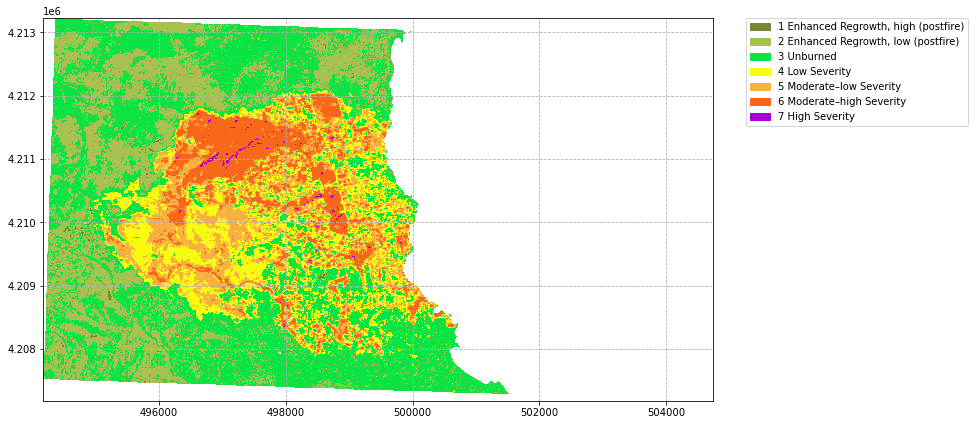

<AxesSubplot:>

In [23]:
colors = [
        '#778835',
        '#a7c050',
        '#0be344',
        '#f8fc11',
        '#f8b140',
        '#f8671a',
        '#a600d4'
]

values = np.unique(np.ma.getdata(burn_severity_masked)) # επιστρέφει τις μοναδικές τιμές κατηγοριοποίησης

# χρώματα για κάθε κατηγορία
label=['Enhanced Regrowth, high (postfire)',
       'Enhanced Regrowth, low (postfire)', 
       'Unburned', 
       'Low Severity',
       'Moderate–low Severity',
       'Moderate–high Severity', 
       'High Severity']

# matplotlib patches, https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html
# τα πλαίσια χρωμάτων στο υπόμνημα
patches = [ mpatches.Patch(color=colors[i], label="{l} {f}".format(l=values[i],f= label[i]) ) for i in range(len(values)) ]

plt.figure(figsize=(10,10))
fig, ax= plt.subplots(ncols=1, figsize=(12, 12))
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
ax.grid(True, linestyle='--')
show(burn_severity_masked[0,:,:], transform=out_meta['transform'], cmap= ListedColormap(colors))

Αντίστοιχα μπορούμε να φτιάξουμε έναν πίνακα με την κατανομή ανά κατηγορία σοβαρότητας.

In [24]:
unique, counts = np.unique(burn_severity_masked, return_counts=True) # πίνακας κατανομής συχνοτήτων

# μετατροπή σε pandas dataframe
# φιλτράρουμε εκτός τα masked data με ~unique.mask
df = pd.DataFrame(data={'Severity category':unique.data[~unique.mask] , 'Label':label, 'Number of Pixels': counts[~unique.mask]}) 

#υπολογισμός ποσοστιαίας κατανομής
df['% per category'] = round((df['Number of Pixels'] / df['Number of Pixels'].sum()) * 100,2) 

# ορισμός στήλης 'Severity category' ως index, χρήσιμο στο επόμενο στάδιο της οπτικοποίησης
df.set_index('Severity category', inplace=True) 
df

,Label,Number of Pixels,% per category
Severity category,,,
1,"Enhanced Regrowth, high (postfire)",418,0.13
2,"Enhanced Regrowth, low (postfire)",60314,18.15
3,Unburned,148009,44.55
4,Low Severity,51941,15.63
5,Moderate–low Severity,42423,12.77
6,Moderate–high Severity,28763,8.66
7,High Severity,372,0.11


Δημιουργούμε ιστόγραμμα συχνοτήτων ή εναλλακτικά διάγραμμα πίτα για την ποσοστιαία κατανομή ανά κατηγορία σοβαρότητας.

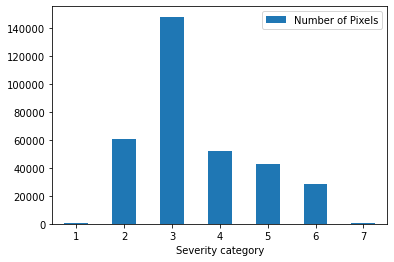

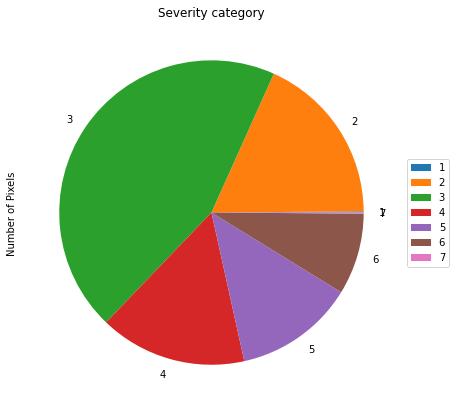

In [25]:
ax = df.plot.bar( y='Number of Pixels',rot=0)
plot = df.plot.pie(y='Number of Pixels', figsize=(7, 7), title='Severity category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

## Ομαδοποίηση της έκταση σε καμένη έκταση και σε μη καμένη με τον αλγόριθμο K-means

Αρχικά πρέπει να μετασχηματίσουμε τα δεδομένα μας στην μορφή με μία μόνο στήλη δηλ να έχουν shape (rows, 1):

In [26]:
X = out_image.reshape((-1,1))
X.shape

(640090, 1)

Στην συνέχεια παραμετροποιούμε και τρέχουμε τον αλγόριθμο `KMeans` από την υπορουτίνα `cluster` της βιβλιοθήκης `scikit-learn`.
Οι παράμετροι έχουν ως εξής:

- `n_clusters`, είναι ο αριθμός των ομάδων που θα ομαδοποιήσει τα δεδομένα ο αλγόριθμος. Δύο στην περίπτωσή μας καμένη/μη καμένη γη.
- `random_state`, ένας ακέραιος που ελέγχει την τυχαιότητα του αρλγόριθμού κατά την αρχικοποίηση του κέντρου καθώς και την αναπαραγωγησιμότητα του αλγορίθμου.
- `max_iter`, μέγιστος αριθμός επαναλήψεων του αλγορίθμου.

In [27]:
# βλ. παράδειγμα: # https://www.acgeospatial.co.uk/k-means-sentinel-2-python/

k_means = cluster.KMeans(n_clusters=2, random_state=31415, max_iter=30)

k_means.fit(X) # υπολογισμός k-means clustering στα δεδομένα RBR.

X_cluster = k_means.labels_ # τα labels_ είναι η κατηγοροιοποίηση σε κατηγορίες, 1 και 0, καμένη και μη καμένη γη αντίστοιχα.
#X_cluster = X_cluster.reshape(img.shape)

# για να εγγράψουμε το αποτέλεσμα σε geotif κάνουμε reshape του πίνακα στις αναγκαίες διαστάσεις.
X_cluster = X_cluster.reshape(out_image[0,:,:].shape) 

# εγγραφή σε geotif
out_meta.update({'dtype': rasterio.uint8})
with rasterio.open(OUTDIR / 'RBR_kmeans_sciki.tif', 'w', **out_meta) as dst:
        dst.write(X_cluster.astype(rasterio.uint8), 1)


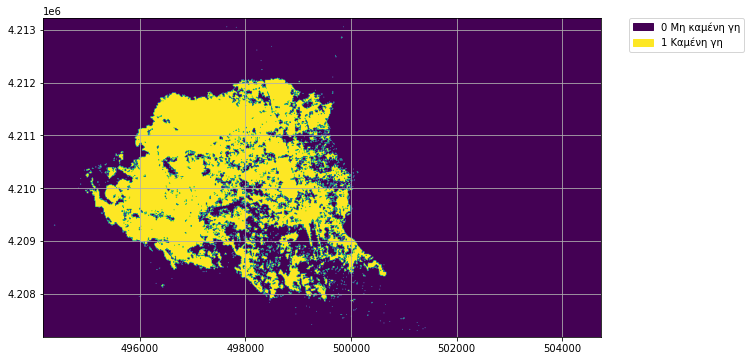

<AxesSubplot:>

In [28]:
values = np.unique(X_cluster.ravel())
plt.figure(figsize=(10,10))
im = plt.imshow(X_cluster, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow


colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
label=["Μη καμένη γη", "Καμένη γη"]
patches = [ mpatches.Patch(color=colors[i], label="{l} {f}".format(l=values[i],f= label[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid()
#plt.show() # αν καλέσουμε την μέθοδο show του matplotlib δεν θα εχει ορθή γεωγραφική αναφορά ο χάρτης
# καλούμε την συνάρτηση show από την βιβλιοθήκη του rasterio.plot 
show(X_cluster, transform=out_meta['transform'])

## Μετατροπή δεδομένων raster σε vector

In [29]:
mask = None
with rasterio.Env():
    with rasterio.open(OUTDIR / 'RBR_kmeans_sciki.tif') as src:
        image = src.read(1) # first band
        crs = src.profile['crs']
        t = src.profile['transform']
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}  # https://fiona.readthedocs.io/en/stable/manual.html#features
            for i, (s, v) in enumerate(features.shapes(image,  mask=mask, transform=src.transform)))
geoms = list(results)


Δημιουργία geopandas dataframe (`kmeans_vector`) με την ομαδοποίηση σε καμένη και μη καμένη γη. Η στήλη `raster_val` λαμβάνει τιμές `1=καμένη` και `0=μη καμένη γη`. Ακολουθεί μετατροπή της στήλης `raster_val` σε ακέραιο τύπο δεδομένων οπτικοποίηση των 10 πρώτων γραμμών του πίνακα.

In [30]:
kmeans_vector  = gpd.GeoDataFrame.from_features(geoms, crs=CRS.to_epsg(crs))

In [31]:
kmeans_vector['raster_val'] = kmeans_vector['raster_val'].astype('int')
kmeans_vector.head(10)

,geometry,raster_val
0,"POLYGON ((497642.124 4213049.519, 497642.124 4...",1
1,"POLYGON ((499850.255 4213049.519, 499850.255 4...",1
2,"POLYGON ((497821.972 4213039.527, 497821.972 4...",1
3,"POLYGON ((499820.280 4212859.679, 499830.272 4...",1
4,"POLYGON ((498491.405 4212679.832, 498491.405 4...",1
5,"POLYGON ((498211.642 4212609.891, 498211.642 4...",1
6,"POLYGON ((499700.382 4212509.975, 499700.382 4...",1
7,"POLYGON ((499710.373 4212489.992, 499710.373 4...",1
8,"POLYGON ((498291.574 4212410.060, 498291.574 4...",1
9,"POLYGON ((498301.566 4212240.204, 498301.566 4...",1


Φιλτράρουμε τον πίνακα `kmeans_vector` και κρατάμε μόνο την καμένη γη (`'raster_val == 1'`)

In [32]:
burnt_area = kmeans_vector.query('raster_val == 1')

οπτικοποιήση σε χάρτη

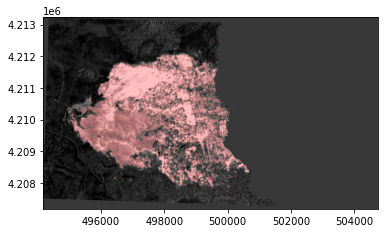

In [33]:
_, ax = plt.subplots()
burnt_area.plot(ax=ax, color='red', alpha=.25) ## alpha είναι ο βαθμο διαφάνειας 
plot=show(contrast_stretching(out_image), transform=t, ax=ax, cmap='gray')

Αποθήκευση του αρχείου σε shapefile.

In [34]:
kmeans_vector.to_file(OUTDIR / 'kmeans.shp')  

/home/leonidas/anaconda3/envs/book/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Στην συνέχεια θα ακολουθήσει ο υπολογισμός της καμένης δομημένης επιφάνειας.
Αρχικά διαβάζουμε το αρχικό shapefile και ελέγχουμε το προβολικό του σύστημα πρέπει να είναι στο `ΕΓΣΑ'87` για να είναι συγκρίσιμο το αρχείο με τα δεδομένα της ομαδοποίησης που έχουμε κάνει.


In [35]:
builtup = gpd.read_file(INPUTDIR / "built_up.shp")
builtup.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Επειδή το αρχείο της δομημένης επιφάνειας είναι στο `WGS'84` κάνουμε μετασχηματισμό σε`ΕΓΣΑ'87` Και συνοπτική διερεύνηση των περιγραφικών δεδομένων του αρχείο.

In [36]:
builtup = builtup.to_crs(2100) # μετασχηματισμός σε ΕΓΣΑ87.
builtup.head() 

,obj_type,name,info,det_method,notation,or_src_id,dmg_src_id,cd_value,real,geometry
0,11-Residential Buildings,Unknown,997-Not Applicable,Not Applicable,Built up area,997,997,Not Applicable,Not Applicable,"POLYGON ((495872.537 4208771.126, 495879.160 4..."
1,11-Residential Buildings,Unknown,997-Not Applicable,Not Applicable,Built up area,997,997,Not Applicable,Not Applicable,"POLYGON ((496642.676 4208195.827, 496656.232 4..."
2,11-Residential Buildings,Unknown,997-Not Applicable,Not Applicable,Built up area,997,997,Not Applicable,Not Applicable,"POLYGON ((495961.019 4208725.414, 495958.471 4..."
3,11-Residential Buildings,Unknown,997-Not Applicable,Not Applicable,Built up area,997,997,Not Applicable,Not Applicable,"POLYGON ((495879.160 4208775.720, 495872.537 4..."
4,11-Residential Buildings,Unknown,997-Not Applicable,Not Applicable,Built up area,997,997,Not Applicable,Not Applicable,"POLYGON ((495824.486 4208374.764, 495880.903 4..."


Και ακολουθεί οπτικοποίηση της γεωγραφικής πληροφορίας της δομημένης επιφάνειας.

<AxesSubplot:>

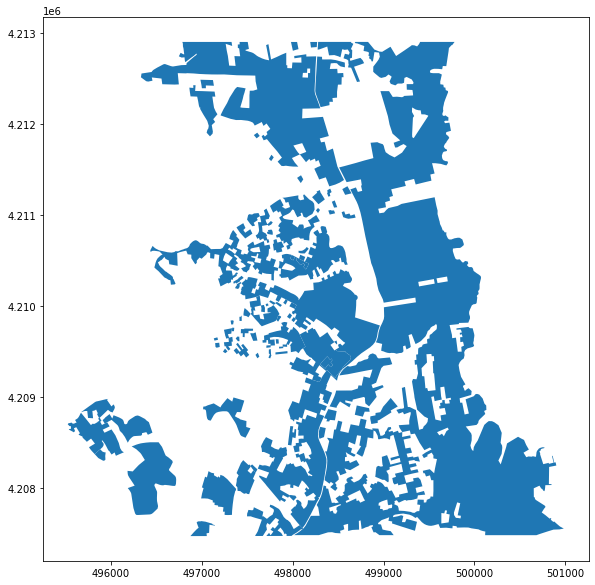

In [37]:
builtup.plot(figsize= (10,10))

Για να εντοπίσουμε την καμένη δομημένη επιφάνεια πρέπει να πάρουμε την τομή (intersection) των δύο αρχείων (του αρχείου με τα πολύγωνα της δομημένης επιφάνειας και του αρχείου με τα πολύγωνα καμένης/μη καμένης γης που προέκυψαν από τον αλγόριθμο k-means.

(Δείτε περισσότερα στο [Set-Operations with Overlay](https://geopandas.org/en/stable/docs/user_guide/set_operations.html) της βιβλιοθήκης geopandas.)

In [38]:
burn_buildup_area = gpd.overlay(builtup, burnt_area, how='intersection') # υπολογισμός τομής των δυο αρχείων

Οπτικοποίηση του αποτελεσματος και αποθήκευση σε geopackage.

/home/leonidas/anaconda3/envs/book/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


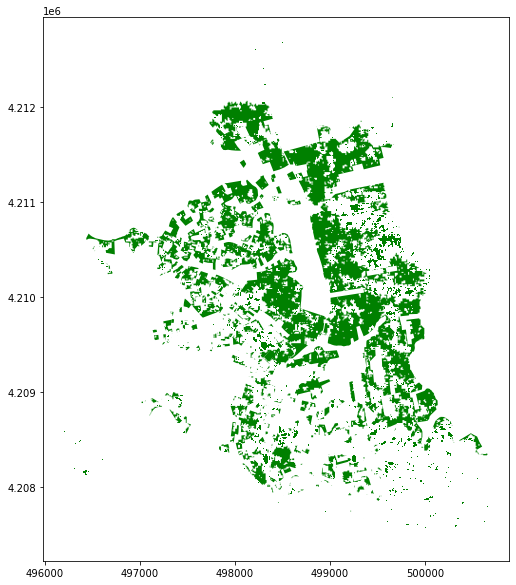

In [39]:
burn_buildup_area.plot(figsize= (10,10), color="green")
burn_buildup_area.to_file(OUTDIR / 'burn_buildup_area.gpkg', driver='GPKG', layer='name')  

Η οπτικοποίηση του αποτελέσματος σε διαδραστικό χάρτη είναι εφικτή μέσω της βιβλιοθήκης folium. 

In [40]:
folium_map = folium.Map(location=[38.0425, 23.9785], zoom_start=13, tiles='OpenStreetMap') # CartoDB positron

for _, r in burn_buildup_area.to_crs(4326).iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['obj_type']).add_to(geo_j)
    geo_j.add_to(folium_map)
folium_map

### Υπολογισμός καμένης δομημένης επιφάνειας

Στην συνέχεια υπολογίζεται η συνολική καμένη επιφάνεια σε στρέμματα. Για κάθε ένα πολύγωνο υπολογίζουμε την έκταση του. Το αποτέλεσμα του υπολογισμού είναι σε $m^{2}$ το οποίο το μετατρέπουμε σε στρέμματα (1 στρ.= 1000 $m^{2}$) . Στην συνέχεια παίρνουμε το άθροισμά τους και εκτυπώνουμε το αποτέλεσμα

In [41]:
# A method
burn_buildup_area["area"] = burn_buildup_area['geometry'].area / 10**3 # τμ σε στρέμματα
b_area = burn_buildup_area["area"].sum()
print(f"Η έκταση της καμένης δομημένης επιφάνειας είναι {round(b_area,2)} στρ.")


Η έκταση της καμένης δομημένης επιφάνειας είναι 3054.92 στρ.


Εναλλακτικά μπορούμε να ενώσουμε όλα τα πολύγωνα και να πάρουμε την έκταση ενός ενιαίου πολυγώνου. Η ένωση των πολυγώνων γίνεταi μέσω της μεθόδου `dissolve`.

In [42]:
# B method
burn_buildup_area_dis = burn_buildup_area.dissolve("raster_val") # https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html#geopandas.GeoDataFrame.dissolve
b_area = float(burn_buildup_area_dis.geometry.area)/10**3
print(f"Η έκταση της καμένης δομημένης επιφάνειας είναι {round(b_area,2)} στρ.")


Η έκταση της καμένης δομημένης επιφάνειας είναι 3054.92 στρ.


### Υπολογισμός καμένης έκτασης ανά ΟΤΑ

Επιπλέον είναι εφικτό να διαπιστώσουμε πόση έκταση έχει καεί ανά ΟΤΑ.
Όπως είδαμε σε προηγούμενο βήμα κατά την οπτικοποίηση του αρχείου των ΟΤΑ, αυτο περιλαμβάνει το σύνολο της Ελλάδας.
Βρίσκουμε την τομή των αρχείων ΟΤΑ και του ομαδοποιημένου με k-means αρχείου.
Στην συνέχεια λαμβάνουμε την έκταση της κάθε γεωμετρίας σε μια νέα στήλη (`area`).

In [43]:
burn_OTA = gpd.overlay(OTA, burnt_area, how='intersection')
burn_OTA['area'] = burn_OTA.geometry.area


Όπως βλέπουμε το αποτέλεσμα πλέον περιορίζεται στην καμένη περιοχή.
Έχει γίνει κατηγοριοποίηση των καμένων περιοχών με βάση των ΟΤΑ στον οποίο ανήκουν.

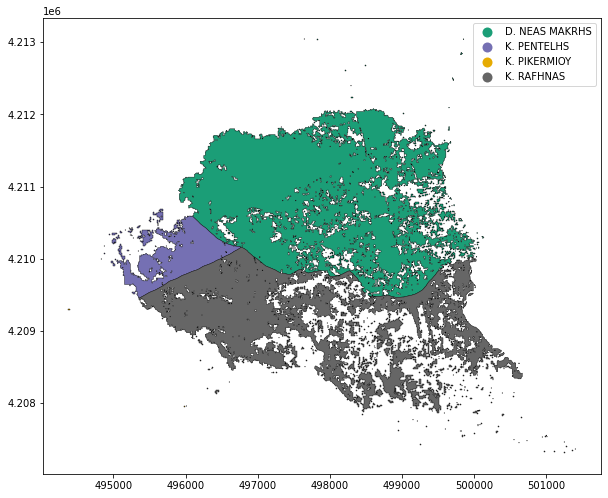

In [44]:
burn_OTA.plot(figsize= (10,10),cmap='Dark2', column='NAME_LATIN', legend=True, edgecolor="black",antialiased=True, linewidth=0.4)
plt.savefig(OUTDIR / 'burn_OTA_area_map.png') #save as png

Για να υπολογίσουμε την καμένη έκταση ανά ΟΤΑ κάνουμε ομάδοποίηση με βάση την τιμή του πεδίου `NAME_LATIN` και υπολογίζουμε το άθροισμα της στήλης `area`. Κάνουμε αναγωγή του αποτελέσματος σε στρέματα.

In [45]:
# Group by cell_id and croptype and calculate total intersection area
burn_OTA_area = burn_OTA.groupby(['NAME_LATIN'])['area'].sum().reset_index()
burn_OTA_area['area'] = burn_OTA_area['area']  / 10**3 # τμ σε στρέμματα

In [46]:
burn_OTA_area = burn_OTA_area.set_index('NAME_LATIN')
burn_OTA_area

,area
NAME_LATIN,
D. NEAS MAKRHS,5809.633000
K. PENTELHS,780.402739
K. PIKERMIOY,0.399324
K. RAFHNAS,3877.550790


Τέλος οπτικοποιούμε την αναλογία της καμένης γης σε ένα διάγραμμα/πίτα (pie chart). Επειδή η καμένη έκταση στην κοινότητα Πικερμίου είναι πολύ μικρή, φιλτράρουμε τα δεδομένα και κρατάμε μόνο έκτάσεις > 500 στρ.

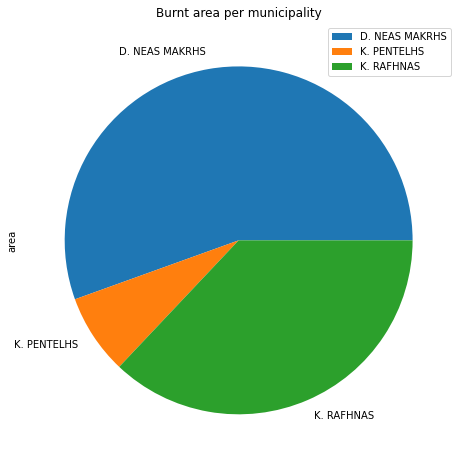

In [47]:
burn_OTA_area = burn_OTA_area[burn_OTA_area['area']>500]

burn_OTA_area.plot(kind='pie', y='area', x='NAME_LATIN',figsize=(8,8),title='Burnt area per municipality')
plt.savefig(OUTDIR / 'burn_OTA_area.png')

## Ευχαριστίες

Ευχαριστώ τον [Βασίλη Λέτσιο](https://www.linkedin.com/in/vasilis-letsios-1b91a9157) για την κοινοποίηση της μεθοδολογίας που ανέπτυξε στα πλαίσια του μαθήματος ["ΕΙΔΙΚΕΣ ΕΦΑΡΜΟΓΕΣ ΤΗΛΕΠΙΣΚΟΠΗΣΗΣ"](https://eclass.uth.gr/courses/PRD_U_122/) για τον υπολογισμό των δεικτών καμένης γης με δεδομενα Sentinel-2.  

## Βιβλιογραφία - Πηγές δεδομένων

Parks, S., Dillon, G., Miller, C., 2014. A New Metric for Quantifying Burn Severity: The Relativized Burn Ratio. Remote Sensing 6, 1827–1844. https://doi.org/10.3390/rs6031827
